# Commit check: updated now



# Core data handling
import numpy as np              # numerical operations and arrays
import pandas as pd             # tabular data loading and manipulation

# Visualisation (EDA and error analysis)
import matplotlib.pyplot as plt # plotting evaluation visuals
import seaborn as sns           # higher-level statistical plots

# Text processing and feature extraction
import re                       # basic text cleaning with regex
from sklearn.feature_extraction.text import TfidfVectorizer  # convert text to weighted features

# Models
from sklearn.linear_model import LogisticRegression  # baseline multi-class text classifier

# Model evaluation
from sklearn.metrics import classification_report   # precision, recall, f1 per class

# Training utilities
from sklearn.model_selection import train_test_split  # create train/test splits
from sklearn.pipeline import Pipeline                 # bundle vectorizer + model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # error analysis


data = pd.read_csv ("customer_support_tickets 2.csv")


data.head()

data.columns


In [9]:
data.isna().sum()


Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64

In [10]:
data[data.isna().any(axis=1)].head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
5,6,Rebecca Fleming,sheenasmith@example.com,53,Male,Microsoft Office,2020-07-28,Cancellation request,Payment issue,I'm facing a problem with my {product_purchase...,Open,NaN,Low,Social media,NaN,NaN,NaN
6,7,Jacqueline Wright,donaldkeith@example.org,24,Other,Microsoft Surface,2020-02-23,Product inquiry,Refund request,I'm unable to access my {product_purchased} ac...,Open,NaN,Critical,Social media,NaN,NaN,NaN
7,8,Denise Lee,joelwilliams@example.com,23,Male,Philips Hue Lights,2020-08-09,Refund request,Battery life,I'm having an issue with the {product_purchase...,Open,NaN,Critical,Social media,NaN,NaN,NaN


In [11]:
critical_cols = [
    "Ticket Subject",
    "Ticket Description",
    "Ticket Type"
]

data[critical_cols].isna().sum()


Ticket Subject        0
Ticket Description    0
Ticket Type           0
dtype: int64

In [13]:
data ["ticket_text"] = (
    data["Ticket Subject"].str.strip() + " " +
    data["Ticket Description"].str.strip()
)

In [15]:
data[["ticket_text", "Ticket Type"]].isna().sum()

ticket_text    0
Ticket Type    0
dtype: int64

In [16]:
data["clean_text"] = data["ticket_text"].copy()


In [17]:
data["clean_text"] = data ["ticket_text"].str.lower()

In [18]:
data["clean_text"] = data["clean_text"].str.replace(r"\s+", " ", regex=True).str.strip()


In [19]:
data["clean_text"] = data["clean_text"].str.replace(r"\b\d{6,}\b", "", regex=True)


In [20]:
data[["ticket_text", "clean_text"]].head()


,ticket_text,clean_text
0,Product setup I'm having an issue with the {pr...,product setup i'm having an issue with the {pr...
1,Peripheral compatibility I'm having an issue w...,peripheral compatibility i'm having an issue w...
2,Network problem I'm facing a problem with my {...,network problem i'm facing a problem with my {...
3,Account access I'm having an issue with the {p...,account access i'm having an issue with the {p...
4,Data loss I'm having an issue with the {produc...,data loss i'm having an issue with the {produc...


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
pd.__version__



'2.2.3'

In [9]:
import os
os.getcwd()


'/Users/graceogunsanwo/Documents/AI-engineering-projects/customer-support-ticket-routing/notebooks'

In [11]:
import os
os.listdir("..")


['.DS_Store',
 'anaconda_projects',
 'Untitled.ipynb',
 '.gitignore',
 '.virtual_documents',
 '.ipynb_checkpoints',
 '.git',
 'notebooks']

In [12]:
import pandas as pd

data = pd.read_csv("../data/customer_support_tickets 2.csv")
data.head()


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [13]:
data.head()


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [15]:
data.columns


Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating'],
      dtype='object')

In [16]:
import re

data["ticket_text"] = (
    data["Ticket Subject"].astype(str).str.strip() + " " +
    data["Ticket Description"].astype(str).str.strip()
)

data["clean_text"] = (
    data["ticket_text"]
      .str.lower()
      .str.replace(r"\s+", " ", regex=True)
      .str.replace(r"\b\d{6,}\b", "", regex=True)
      .str.strip()
)


In [17]:
data.columns


Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating', 'ticket_text', 'clean_text'],
      dtype='object')

In [18]:
X = data["clean_text"]
y = data["Ticket Type"].astype(str).str.strip()


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [20]:
X_train.shape, X_test.shape


((6775,), (1694,))

In [21]:
pd.DataFrame({
    "train": y_train.value_counts(normalize=True),
    "test": y_test.value_counts(normalize=True)
}).fillna(0).round(3)


,train,test
Ticket Type,,
Refund request,0.207,0.207
Technical issue,0.206,0.206
Cancellation request,0.200,0.200
Product inquiry,0.194,0.194
Billing inquiry,0.193,0.193


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
        min_df=2
    )),
    ("clf", LogisticRegression(max_iter=2000))
])

model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LogisticRegression(max_iter=2000))])

In [23]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


                      precision    recall  f1-score   support

     Billing inquiry       0.21      0.21      0.21       327
Cancellation request       0.21      0.20      0.20       339
     Product inquiry       0.21      0.20      0.21       328
      Refund request       0.18      0.19      0.18       351
     Technical issue       0.21      0.23      0.22       349

            accuracy                           0.21      1694
           macro avg       0.21      0.21      0.21      1694
        weighted avg       0.21      0.21      0.21      1694



In [24]:
pred_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": y_pred
})

pred_df[pred_df["true_label"] != pred_df["pred_label"]].head(10)


,text,true_label,pred_label
6510,installation support i'm having an issue with ...,Product inquiry,Cancellation request
4921,refund request i'm having an issue with the {p...,Refund request,Cancellation request
871,cancellation request i'm having an issue with ...,Billing inquiry,Cancellation request
6086,account access i'm having an issue with the {p...,Product inquiry,Billing inquiry
3305,cancellation request i'm having an issue with ...,Refund request,Cancellation request
7739,peripheral compatibility i'm having an issue w...,Cancellation request,Technical issue
6339,refund request i'm having an issue with the {p...,Technical issue,Cancellation request
7811,network problem i'm having an issue with the {...,Technical issue,Product inquiry
6844,delivery problem i'm facing issues logging int...,Refund request,Billing inquiry
563,battery life i'm having an issue with the {pro...,Billing inquiry,Cancellation request


## Notes

This notebook implements a baseline text classification model for routing customer support tickets.  
Initial results are close to random performance due to overlapping category language, establishing a clear baseline for iterative improvement.


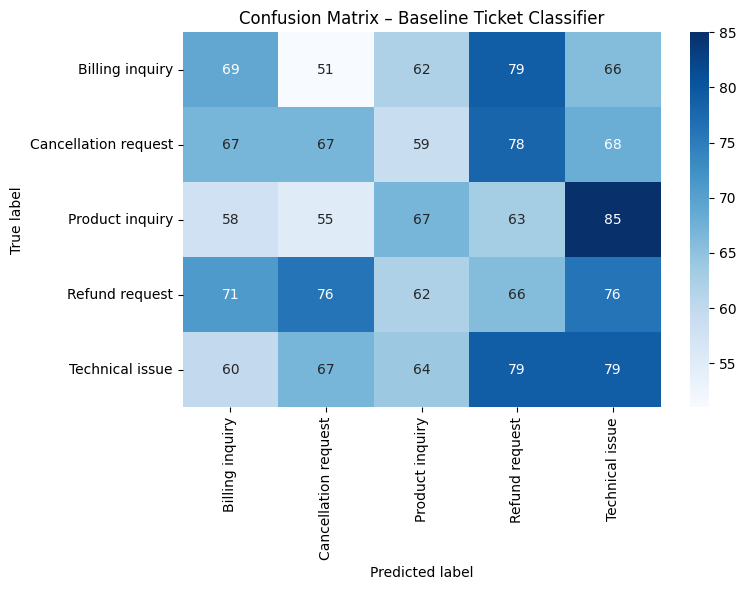

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=model.classes_,
    yticklabels=model.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Baseline Ticket Classifier")
plt.tight_layout()
plt.show()


## Error Analysis (Baseline)

The confusion matrix shows frequent misclassification between semantically similar categories such as Billing, Refunds, and Cancellations.  
This indicates that unigram and bigram TF-IDF features alone are insufficient to clearly separate overlapping customer intents.  
The baseline model therefore serves as a diagnostic reference point for feature and model improvements rather than a production-ready solution.


In [28]:
from sklearn.svm import LinearSVC

svc_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.9
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

svc_model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 3),
                                 stop_words='english')),
                ('clf', LinearSVC(class_weight='balanced'))])

In [29]:
y_pred_svc = svc_model.predict(X_test)

print(classification_report(y_test, y_pred_svc))


                      precision    recall  f1-score   support

     Billing inquiry       0.25      0.28      0.26       327
Cancellation request       0.19      0.17      0.18       339
     Product inquiry       0.21      0.22      0.22       328
      Refund request       0.21      0.20      0.20       351
     Technical issue       0.19      0.19      0.19       349

            accuracy                           0.21      1694
           macro avg       0.21      0.21      0.21      1694
        weighted avg       0.21      0.21      0.21      1694



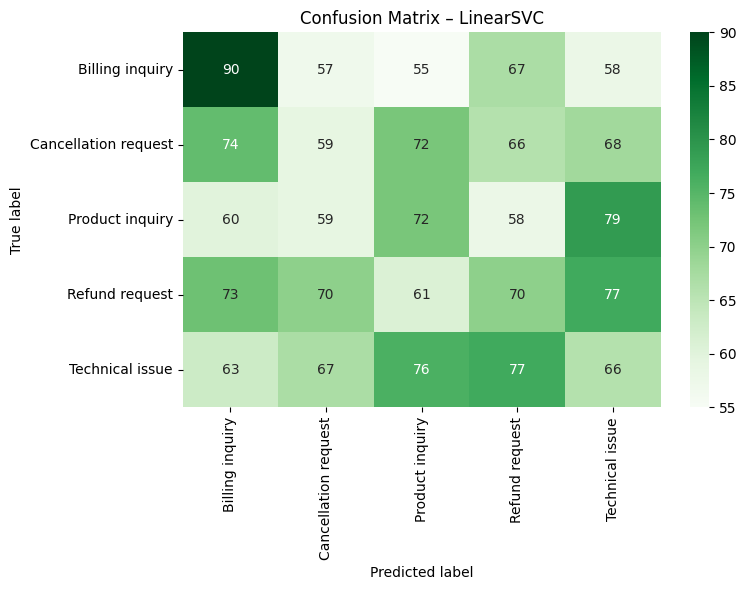

In [30]:
from sklearn.metrics import confusion_matrix

cm_svc = confusion_matrix(y_test, y_pred_svc, labels=svc_model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_svc,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=svc_model.classes_,
    yticklabels=svc_model.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – LinearSVC")
plt.tight_layout()
plt.show()


## Model Comparison: LinearSVC

Replacing Logistic Regression with a Linear Support Vector Classifier improved class separation for certain ticket categories, particularly where intent phrases are more distinct.  
However, significant confusion remains between Billing, Refunds, and Cancellations, indicating that label overlap and user language ambiguity remain key challenges.
